(2080, 2)
(2080, 2)


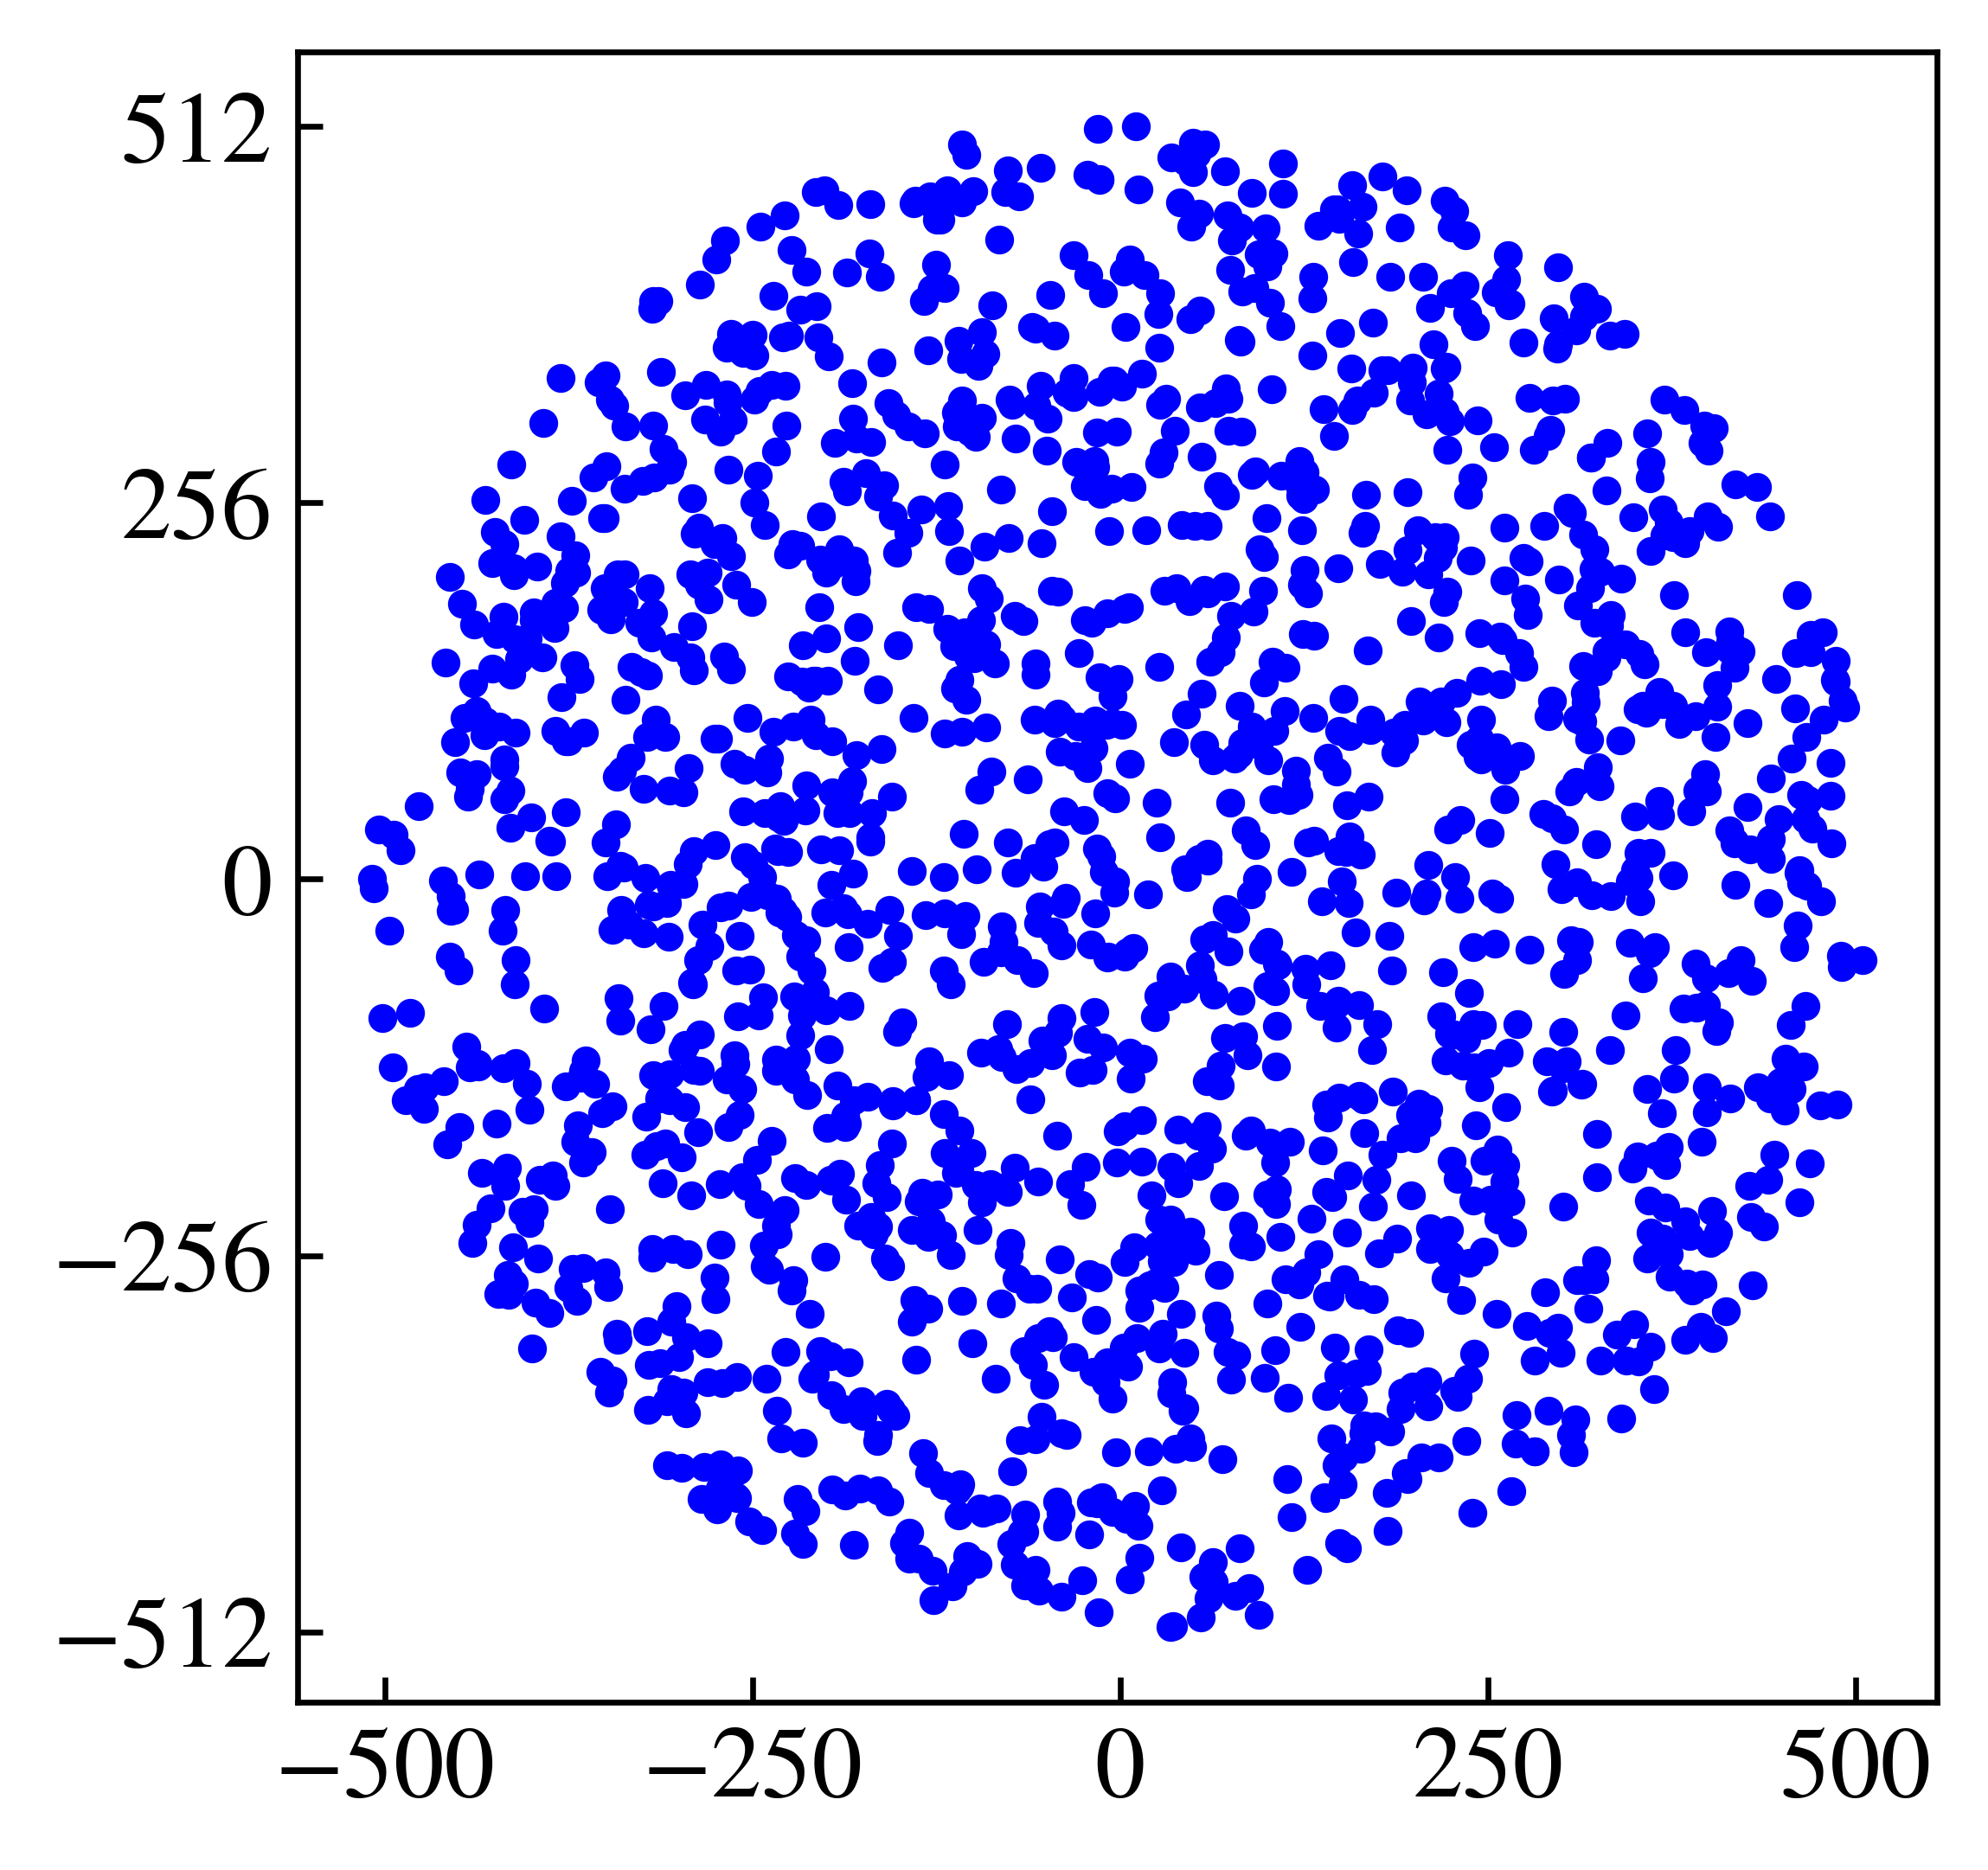

In [ ]:
import numpy as np
from structure_factor.point_processes import HomogeneousPoissonPointProcess
from structure_factor.spatial_windows import BoxWindow
from structure_factor.hyperuniformity import subwindows, multiscale_test
import matplotlib.pyplot as plt
import pandas as pd  # for CSV output
from structure_factor.data import load_data
from structure_factor.hyperuniformity import effective_hyperuniformity
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
from structure_factor.tapered_estimators_isotropic import (
    allowed_k_norm_bartlett_isotropic,
)
from structure_factor.spatial_windows import BallWindow
import structure_factor.utils as utils
import matplotlib.pyplot as plt
from structure_factor.hyperuniformity import bin_data
from structure_factor.point_processes import HomogeneousPoissonPointProcess
from structure_factor.spatial_windows import BoxWindow
from pathlib import Path


from matplotlib import rcParams
from scipy.stats import linregress
import os
import cv2

FS=14
rcParams['figure.dpi']  = 600
rcParams['savefig.dpi'] = 600
rcParams['font.size'] = FS
rcParams['font.family'] = 'StixGeneral'
rcParams["mathtext.fontset"] = 'stix'
# rcParams["mathtext.default"] = "it" 
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
plt.rc('font', size=FS)          # controls default text sizes
plt.rc('axes', labelsize=FS)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FS)    # fontsize of the tick labels
plt.rc('legend', fontsize=FS)    # legend fontsize
plt.rc('figure', titlesize=FS+2)   # fontsize of the figure title


output_dir_data =Path("../Fig5")
output_dir_data.mkdir(parents=True, exist_ok=True)


point_process = HomogeneousPoissonPointProcess(intensity=0.002)
window = BoxWindow(bounds=[[-512, 512], [-512, 512]])
point_pattern = point_process.generate_point_pattern(window=window)

pts= point_pattern.points

print(pts.shape)
sf = StructureFactor(point_pattern)
# fig, ax = plt.subplots(figsize=(6,6),dpi=600)
# ax = point_pattern.plot(axis=ax)
# ax.set_aspect("equal", "box")
# plt.tight_layout(pad=1)

points = pts
mask = np.sqrt(points[:, 0]**2 + points[:, 1]**2) < 512

print(points.shape)
fig, ax = plt.subplots(figsize=(4,4),dpi=600)
ax.plot(points[mask, 0], points[mask, 1], "b.")
ax.set_aspect("equal", "box")
plt.tight_layout(pad=1)
ax.set_yticks([-512, -256, 0, 256, 512]) 
fig.savefig(output_dir_data / f"Poisson_point_process(PPP).png", dpi=600)

## Poission point process S(k) 

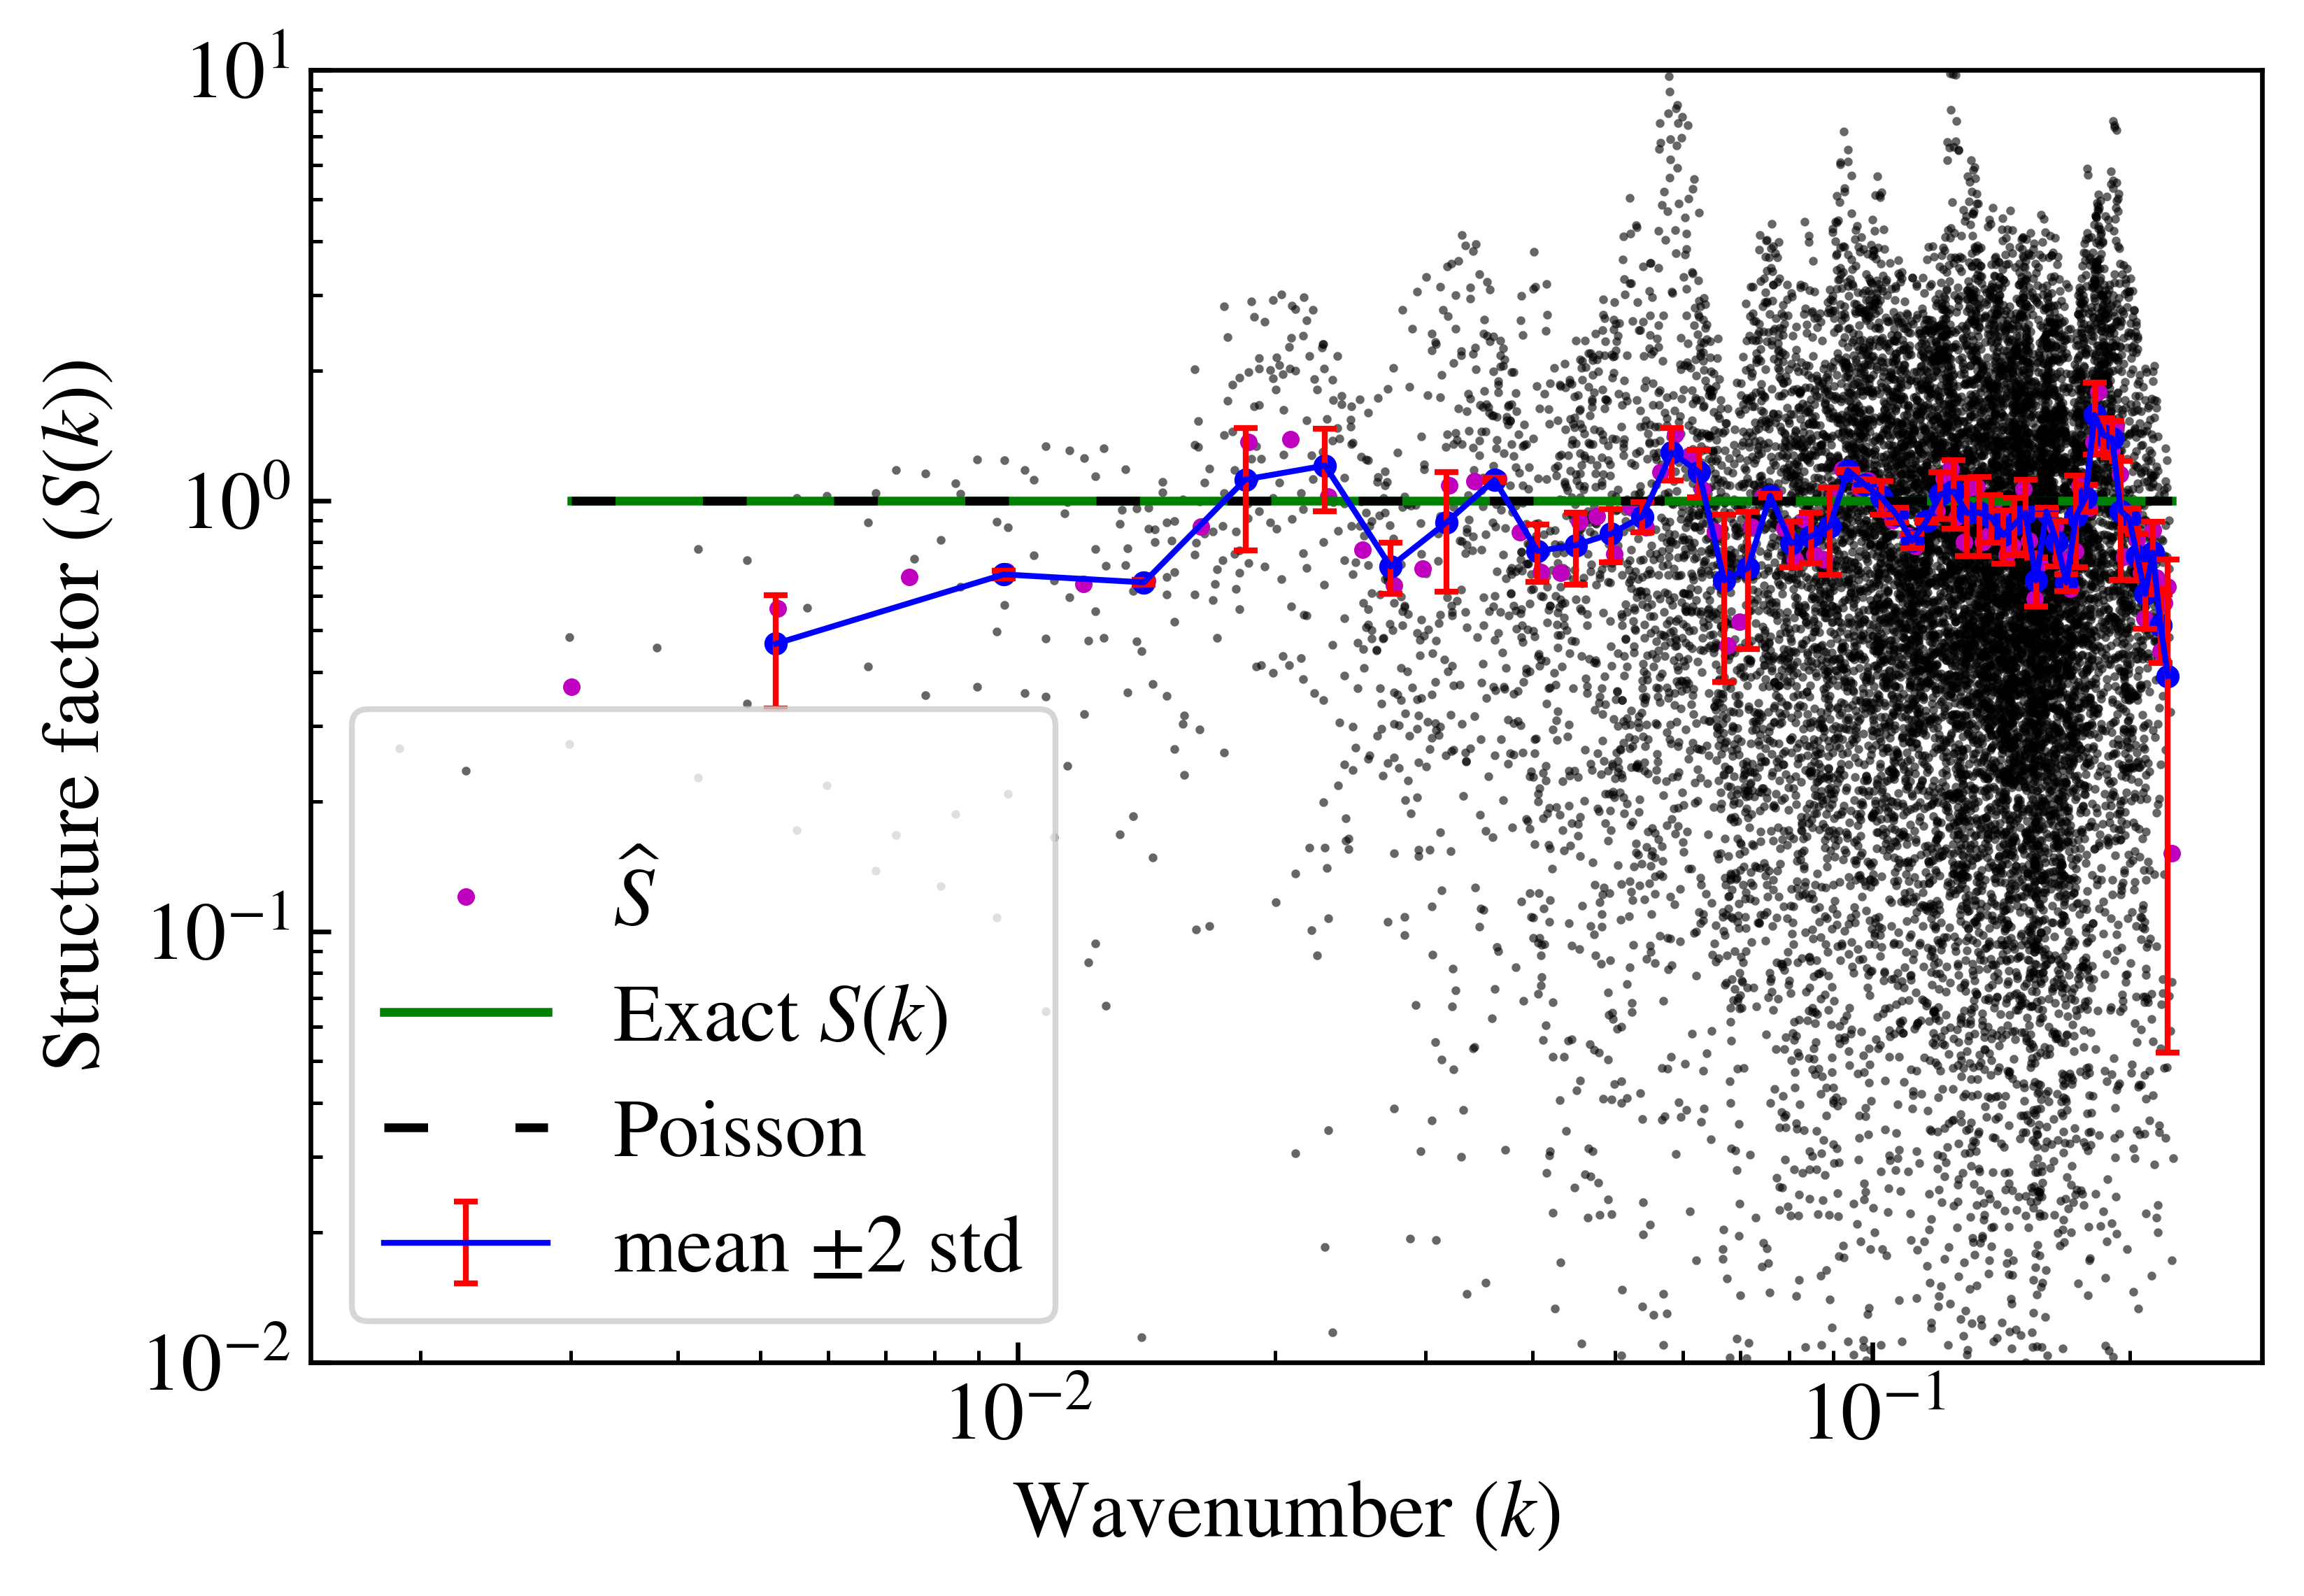

<Figure size 3840x2880 with 0 Axes>

In [27]:
x = np.linspace(0, 1.0/2.0/np.pi, 120)
x = x[x != 0]
k = utils.meshgrid_to_column_matrix(np.meshgrid(x, x))
k, sf_estimated = sf.scattering_intensity(k)

# bin_data
k_norm = utils.norm(k)
k_norm_binned, sf_estimated_binned, _ = bin_data(k_norm, sf_estimated,bins=100)

fig, ax = plt.subplots(figsize=(6, 4),dpi=600)
ax.plot(k_norm, sf_estimated, "k.", label=" ", alpha = 0.6, markersize=1, rasterized=True)
ax.set_ylim([0.01,10])
sf.plot_isotropic_estimator(
    k_norm_binned,
    sf_estimated_binned,
    axis=ax,
    color="m",
    error_bar=True,
    bins=50,
    exact_sf=point_process.structure_factor,
    # label="After regularization",
    file_name=Path(f"{output_dir_data}/Poisson"),
)
ax.legend()
plt.tight_layout(pad=1)

## GinibrePointProcess = theoretical DHU point

In [ ]:
import matplotlib.pyplot as plt

from structure_factor.point_processes import GinibrePointProcess
from structure_factor.spatial_windows import BallWindow

def ginibre_radius_for_points(N):
    return np.sqrt(N)

N = 2000
Scale_len = 512.0

R = ginibre_radius_for_points(N)

point_process = GinibrePointProcess()
window = BallWindow(center=[0, 0], radius=R)
points = point_process.generate_sample(window=window)
print(points.shape)

points = Scale_len *points/R

fig, ax = plt.subplots(figsize=(4,4),dpi=600)
ax.plot(points[:, 0], points[:, 1], "b.")
ax.set_aspect("equal", "box")
plt.tight_layout(pad=1)
ax.set_yticks([-512, -256, 0, 256, 512]) 
fig.savefig(output_dir_data / f"GinibrePointProcess (DHU).png", dpi=600)


In [ ]:
from structure_factor.point_pattern import PointPattern
pts = points
# --------------------------------------------------
# 2) Define window = BoxWindow([...])
# --------------------------------------------------
x = pts[:,0] 
y = pts[:,1]
bounds = np.array([
    [x.min(), x.max()],   # x-range
    [y.min(), y.max()],   # y-range
])
window = BoxWindow(bounds=bounds)
# --------------------------------------------------
# 3) Define intensity and build PointPattern
# --------------------------------------------------
N = pts.shape[0]
volume = window.volume             # area in 2D
intensity = N / volume      # λ = N / |W|
point_pattern = PointPattern(points=pts, window=window, intensity=intensity)

sf = StructureFactor(point_pattern)

# fig, ax = plt.subplots(figsize=(6,6),dpi=600)
# point_pattern.plot(axis=ax)
# ax.set_aspect("equal", "box")
# ax.set_yticks([-512, -256, 0, 256, 512]) 
# plt.tight_layout(pad=1)


In [ ]:
x = np.linspace(0, 1.0/2.0/np.pi, 100)
x = x[x != 0]
k = utils.meshgrid_to_column_matrix(np.meshgrid(x, x))
k, sf_estimated = sf.scattering_intensity(k)

bin_num=60
# bin_data
k_norm = utils.norm(k)
k_norm_binned, sf_estimated_binned, bin_std = bin_data(k_norm, sf_estimated,bins=bin_num)

df = pd.DataFrame({
    "bin_center": k_norm_binned,
    "bin_mean":   sf_estimated_binned,
    "bin_std":    bin_std
})

# Standared hyperuniform poitn patterns
# from structure_factor.point_processes import GinibrePointProcess
# point_process2 = GinibrePointProcess()
# exact_sf = point_process2.structure_factor

fig, ax = plt.subplots(figsize=(6, 4),dpi=600)
ax.plot(k_norm, sf_estimated, "k.", label=" ",alpha = 0.6, markersize=1, rasterized=True)
ax.set_ylim([0.01,100])
sf.plot_isotropic_estimator(
    k_norm_binned,
    sf_estimated_binned,
    axis=ax,
    color="m",
    error_bar=True,
    # plot_type="radial",
    bins=bin_num,
    # exact_sf=point_process2.structure_factor,
    # label="After regularization",
    file_name=Path(f"{output_dir_data}/GinibrePointProcess"),
)
# Save to CSV
file_name=Path(f"{output_dir_data}/GinibrePointProcess")
df.to_csv(f"{file_name}_binned_statistics.csv", index=False)


### ThomasPointProcess: aggregation patterns

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from structure_factor.point_processes import ThomasPointProcess
from structure_factor.spatial_windows import BallWindow

N_target = 2000
radius = 60
kappa_target = N_target / (np.pi * radius**2 * 20)
window = BallWindow(center=[0, 0], radius=radius)
point_process = ThomasPointProcess(kappa=kappa_target, mu=20, sigma=2)

point_pattern = point_process.generate_point_pattern(window=window)
# ax = point_pattern.plot()
# ax.set_aspect("equal", "box")
# plt.tight_layout(pad=1)

points = point_pattern.points   # <------ THE KEY LINE
points = points - np.mean(points, axis=0)
points = Scale_len *points/max(points[:,1])
print(points.shape)
print(points[:5])

fig, ax = plt.subplots(figsize=(4,4),dpi=600)
ax.plot(points[:, 0], points[:, 1], "b.")
ax.set_aspect("equal", "box")
plt.tight_layout(pad=1)
# ax.set_yticks([-20, -10, 0, 10, 20]) 
fig.savefig(output_dir_data / f"ThomasPointProcess (Aggregation).png", dpi=600)

In [ ]:
from structure_factor.point_pattern import PointPattern
pts = points
# --------------------------------------------------
# 2) Define window = BoxWindow([...])
# --------------------------------------------------
x = pts[:,0] 
y = pts[:,1]
bounds = np.array([
    [x.min(), x.max()],   # x-range
    [y.min(), y.max()],   # y-range
])
window = BoxWindow(bounds=bounds)
# --------------------------------------------------
# 3) Define intensity and build PointPattern
# --------------------------------------------------
N = pts.shape[0]
volume = window.volume             # area in 2D
intensity = N / volume      # λ = N / |W|
point_pattern = PointPattern(points=pts, window=window, intensity=intensity)

sf = StructureFactor(point_pattern)

# ax = point_pattern.plot()
# ax.set_aspect("equal", "box")
# plt.tight_layout(pad=1)

In [ ]:
x = np.linspace(0, 1.0/2.0/np.pi, 100)
x = x[x != 0]
k = utils.meshgrid_to_column_matrix(np.meshgrid(x, x))
k, sf_estimated = sf.scattering_intensity(k)

bin_num=80
# bin_data
k_norm = utils.norm(k)
k_norm_binned, sf_estimated_binned, bin_std = bin_data(k_norm, sf_estimated,bins=bin_num)

df = pd.DataFrame({
    "bin_center": k_norm_binned,
    "bin_mean":   sf_estimated_binned,
    "bin_std":    bin_std
})

# Standared hyperuniform poitn patterns
# from structure_factor.point_processes import GinibrePointProcess
# point_process2 = GinibrePointProcess()
# exact_sf = point_process2.structure_factor

fig, ax = plt.subplots(figsize=(6, 4),dpi=600)
ax.plot(k_norm, sf_estimated, "k.", label=" ",alpha = 0.6, markersize=1, rasterized=True)
ax.set_ylim([0.01,100]) 
sf.plot_isotropic_estimator(
    k_norm_binned,
    sf_estimated_binned,
    axis=ax,
    color="m",
    error_bar=True,
    # plot_type="radial",
    bins=40,
    # exact_sf=point_process2.structure_factor,
    # label="After regularization",
    file_name=Path(f"{output_dir_data}/ThomasPointProcess"),
)

# Save to CSV
file_name=Path(f"{output_dir_data}/ThomasPointProcess")
df.to_csv(f"{file_name}_binned_statistics.csv", index=False)